# Pose Detection with AlphaPhose

This notebook uses an open source project [MVIG-SJTU/AlphaPose](https://github.com/MVIG-SJTU/AlphaPose) to detect/track multi person poses on a given youtube video.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install AlphaPose

In [0]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/MVIG-SJTU/AlphaPose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q -b pytorch --depth 1 $git_repo_url
  !cd $project_name && pip install -q -r requirements.txt
  !pip install -q youtube-dl visdom
  
import sys
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

from IPython.display import YouTubeVideo

## Download pretrained models

In [0]:
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=$file_id" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=$confirm_text&id=$file_id" -o $file_name
  

  
pretrained_model_path = join(project_name, 'models/sppe/duc_se.pth')
if not exists(pretrained_model_path):
  # download the pretrained model
  download_from_google_drive('1OPORTWB2cwd5YTVBX-NE8fsauZJWsrtW', pretrained_model_path)
  
yolo_pretrained_model_path = join(project_name, 'models/yolo/yolov3-spp.weights')
if not exists(yolo_pretrained_model_path):
  # download the YOLO weights
  download_from_google_drive('1D47msNOOiJKvPOXlnpyzdKA3k6E97NTC', yolo_pretrained_model_path)

## Detect poses on a test video

We are going to detect poses on the following youtube video:

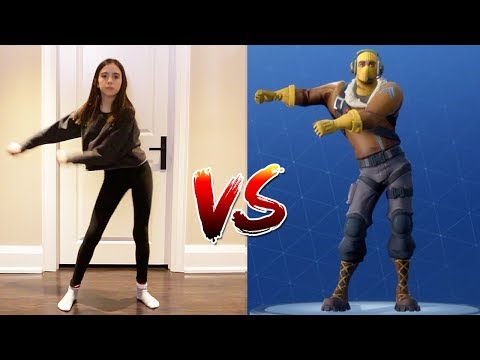

In [0]:
YOUTUBE_ID = 'RXABo9hm8B8'


YouTubeVideo(YOUTUBE_ID)

Download the above youtube video, cut the first 5 seconds and do the pose detection on that 5 seconds:

In [0]:
!rm -df youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# cut the first 5 seconds
!ffmpeg -y -loglevel info -i youtube.mp4 -t 5 video.mp4
# run AlpaPose on these 5 seconds video
!rm -rf AlphaPose_video.avi
!cd $project_name && python3 video_demo.py --sp --video ../video.mp4 --outdir .. --save_video
# convert the result into MP4
!ffmpeg -y -loglevel info -i AlphaPose_video.avi AlphaPose_video.mp4

Finally, visualize the result:

In [0]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('AlphaPose_video.mp4', width=960, height=720)